In [1]:
from __future__ import print_function, division
import numpy as np
import MDP
import RL2
from Utils2 import generate_bandit_data_for_plot, plot_avg_cumulative_reward
%matplotlib inline


def sampleBernoulli(mean):
    ''' function to obtain a sample from a Bernoulli distribution

    Input:
    mean -- mean of the Bernoulli
    
    Output:
    sample -- sample (0 or 1)
    '''

    if np.random.rand(1) < mean: return 1
    else: return 0


# Multi-arm bandit problems (3 arms with probabilities 0.3, 0.5 and 0.7)
T = np.array([[[1]],[[1]],[[1]]])
R = np.array([[0.3],[0.5],[0.7]])
discount = 0.999
mdp = MDP.MDP(T,R,discount)
banditProblem = RL2.RL2(mdp,sampleBernoulli)

## Question 1: Multi-arm Bandit
The following cell shows the results of running Bandit problem for one trial of 200 iterations. The evaluation of the results can be found after the results block

In [2]:
# Test epsilon greedy strategy
empiricalMeans = banditProblem.epsilonGreedyBandit(nIterations=200)
print ("\nepsilonGreedyBandit results")
print (empiricalMeans)

# Test Thompson sampling strategy
empiricalMeans = banditProblem.thompsonSamplingBandit(prior=np.ones([mdp.nActions,2]),nIterations=200)
print ("\nthompsonSamplingBandit results")
print (empiricalMeans)

# Test UCB strategy
empiricalMeans = banditProblem.UCBbandit(nIterations=200)
print ("\nUCBbandit results")
print (empiricalMeans)


epsilonGreedyBandit results
[ 0.68]

thompsonSamplingBandit results
[ 0.655]

UCBbandit results
[ 0.61]


The above results are for one trial and show that epsilon greedy bandit with a constant $epsilon=0.3$. The value was chosen after cross-validation of different epsilon values. The constant epsilon value can vary based on number of actions in the problem and their repective probabilities. The initial counter, hoeffding term and Q-value for each action starts at 1 for consistency. The value of k (number of samples) for thompson sampling is 1. The results are not consistent from single trial as the final value varies in different trials. We should look at the results from the graphs to understand the results better.

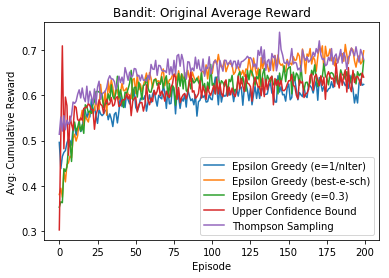

In [3]:
bandit_results = generate_bandit_data_for_plot(banditProblem)
plot_legend = bandit_results.pop(-1)
plot_title = "Bandit: Original Average Reward"
plot_avg_cumulative_reward(bandit_results, plot_legend, plot_title, 
                           None, use_ax_limit=False)

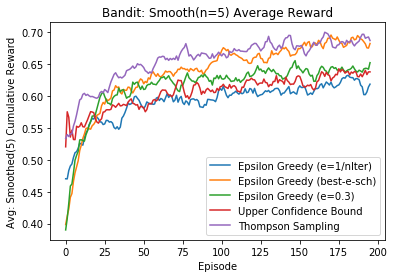

In [4]:
#plot smoothed curves
plot_title = "Bandit: Smooth(n=5) Average Reward"
plot_avg_cumulative_reward(bandit_results, plot_legend, plot_title, 
                           None, n=5, smooth=True, use_ax_limit=False)

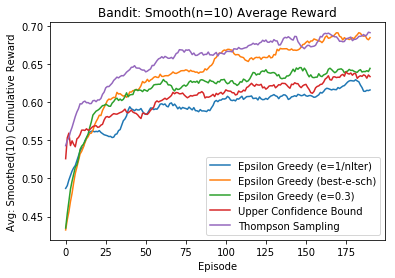

In [5]:
plot_title = "Bandit: Smooth(n=10) Average Reward"
plot_avg_cumulative_reward(bandit_results, plot_legend, plot_title, 
                           None, n=10, smooth=True, use_ax_limit=False)

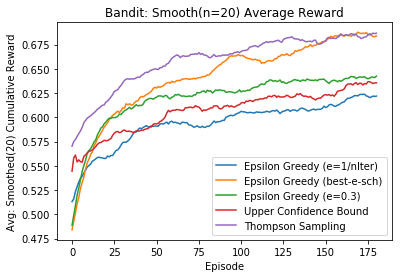

In [6]:
plot_title = "Bandit: Smooth(n=20) Average Reward"
plot_avg_cumulative_reward(bandit_results, plot_legend, plot_title, 
                           None, n=20, smooth=True, use_ax_limit=False)

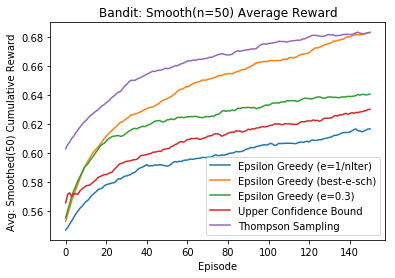

In [7]:
plot_title = "Bandit: Smooth(n=50) Average Reward"
plot_avg_cumulative_reward(bandit_results, plot_legend, plot_title, 
                           None, n=50, smooth=True, use_ax_limit=False)
#the following graph is smoothed too much.
#Please refer to previous (n=20) graph for better visualization and following analysis.

The above cells shows the results for bandit problem using different algorithms. The epsilon greedy(e=0.3) has an epsilon value selected through cross-validation of results. The Thompson sampling algorithm is able to perform the best in terms of cumulative reward, however the decaying epsilon is very close to achieving best results. The decay rate of epsilon is $0.0016$, with initial value of $0.3$. Essentially it decays to an epsilon of 0 when number of iterations is 180. I also tried a decay of $0.0015$ so that we achieve an epsilon value of 0 at iteration 200, however, the graph can't clearly show that the final results are equal to Thompson sampling. But either way we would get a value close to 0.7 (which is the highest probability of the best action).

The epsilon greedy algorithm chooses an action at random with probability $epsilon=0.3$ for graph (e=0.3) and chooses a greedy action other times. The greedy action is picked based on the best emperical mean of each action. The emperical mean is calculated by dividing the total reward from one action by the total number of times the arm was pulled. Once the number of samples are sufficient we achieve a good estimate of the reward of each action. This improved estimate helps us improve the results of the algorithm. The graph shows that the estimate linearly becomes better as the cumulative reward linearly increases, but it never achieves the highest value of 0.7 (arm=3) because of the constant random selection of action with probability $e=0.3$. 

Using an epsilon greedy algorithm with decaying epsilon, we see that the final estimate is the same as Thompson sampling. We see that with constant epsilon, we get a linear regret and with a decaying epsilon, we get a logrithmmic regret. We can see from the results that decaying epsilon is better. However, in non-stationary bandit environments; using a decaying epsilon could be costly as we would stop exploring and be stuck in a non-optimal solution after some time. The graph with (best-e-sch) shows the results with best epsilon decay schedule. We see that by iteration=180, the epsilon is reduced to 0 and thus we are acting greedily and we always pick the action with highest probability. Because the estimates of each action are close to true values, we are able to achieve highest reward.

The graph with $epsilon=1/nIterations$ is the graph which was required for the assignment, it shows that without a good epsilon decay, the epsilon greedy is not able to achieve the highest reward. The $epsilon=1/nIterations$ has a linearly increasing slope which shows that the epsilon value is reducing. The final epsilon ends up being $0.005$ which is very small but not zero. This result is very surprising as the decaying epsilon value performed worse than using a constant value of epsilon. The decaying epsilon in this case should have also generated a logarithimic regret, but it seems that our estimate of each action wasn't very good and thus we weren't able to perform well. I think the reason our estimate is not very good is because the algorithm only gets 10 iterations before the epsilon value is $0.1$. Theoretically, it would make sense to have a logarithimic regret, however, that is true after we have achieved a true estimate of the actions. In this assignment we are trying to estimate the value of each action and reduce the value of epsilon at the same time. This becomes problamatic and doesn't give us logarithimic regret results. Instead, I provide a best case epsilon decay which is able to achieve good results because of the cautious decay in epsilon.

The results of UCB are understandably worse than the best epsilon greedy technique and Thompson sampling because UCB is based around the uncertainty of choosing an action. The denominator of the hoeffding term represents the uncertainity in the estimate. Thus larger the uncertainity of an actions' value, the higher change of the action being selected. Thus, by maintaining the counters, we can represent the best action to pick based on the actual current estimate of that action + the uncertainity of the estimate of that action. As the counter $N(a)$ for one action increases the uncertainity decreases for that action and increases for other action. Using a log, helps reduce the rate of increase in uncertainity while still keeping it unbounded. The graph shows that as the value of $N$ increases the estimates of the action become better and we are able to achieve better cumulative reward. However, the results are worse than epsilon greedy. I think the reason for this is that we are missing the use of confidence constant $c$ (as explained in et. al Sutton- Intro to RL) which is multiplied to the hoeffding term. The constant gives weighting to the uncertainity term and thus helps with faster convergence.

The results for thompson sampling are understandably better than all algorithms as it models the probability of reward of each action using a Beta distribution (prior) and this helps in picking the action which has the highest possibility of reward of $1$. The best action is based on the highest mean of all actions. The mean is calcuated by sampling $k$ elements from the beta distribution. In the above graphs, $k=1$. This means that for distributions with high variance (when the number of samples are low-early in the nIterations); we end up sampling "practically" randomly as the distribution is close to uniform. As the number of samples increase and our estimates of the actions' reward become better, the variance of beta distribution decreases and we start sampling values closer to the true mean. This helps us get more greedy over time based on the actual value of the rewards over time. If we increase the value of $k$, we will essentially reduce the randomness in the begining of the algorithm as with larger number of estimates, we will have a learning curve with slower convergence. In the graph we see that the Thompson sampling is the fastest to converge to the optimal value and this agrees with the theory because we are modeliing the probabilities using beta distribution and keep updating the distribution as we see more data.